## 어텐션을 이용한 텍스트 요약(Text Summarization with Attention mechanism)

텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환하는 것을 말합니다. 읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 글을 많이 쓰는 사람들에게는 꼭 필요한 능력 중 하나인 것 같습니다. 그런데 만약 기계가 이를 자동으로 해줄 수만 있다면 얼마나 좋을까요? 이번 실습에서는 그 중 한 가지 방법인 seq2seq를 구현해보겠습니다. 그리고 어텐션 메커니즘(attention mechanism)을 적용해봅시다.

### 1. 텍스트 요약(Text Summarization)

텍스트 요약은 크게 추출적 요약(extractive summarization)과 추상적 요약(abstractive summarization)으로 나뉩니다.

#### 1) 추출적 요약(extractive summarization)

추출적 요약은 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법입니다. 그렇기 때문에 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들입니다. 추출적 요약의 대표적인 알고리즘으로 머신 러닝 알고리즘인 텍스트랭크(TextRank)가 있는데, 아래의 링크에서 텍스트랭크로 구현된 세 줄 요약기를 시험해볼 수 있습니다.

링크 : https://summariz3.herokuapp.com/

위 링크로 이동하여 인터넷 뉴스나 가지고 있는 글을을 복사 + 붙여넣기하여 결과를 살펴보세요. 세 개의 문장은 전부 원문에 존재하던 문장들입니다. 이 방법의 단점이라면, 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한된다는 점입니다.

그렇다면 마치 사람처럼 원문에 없던 단어나 문장을 사용하면서 핵심만 간추려서 표현하는 요약 방법은 없을까요?

#### 2) 추상적 요약(abstractive summarization)

추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법입니다. 마치 사람이 요약하는 것 같은 방식인데, 당연히 추출적 요약보다는 난이도가 높습니다. 이 방법은 주로 인공 신경망을 사용하며 대표적인 모델로 seq2seq가 있습니다. 이 방법의 단점이라면 seq2seq와 같은 인공 신경망들은 기본적으로 지도 학습이라는 점입니다. 다시 말해 추상적 요약을 인공 신경망으로 훈련하기 위해서는 '원문' 뿐만 아니라 '실제 요약문'이라는 레이블 데이터가 있어야 합니다. 그렇기 때문에 데이터를 구성하는 것 자체가 하나의 부담입니다. 이번 챕터에서는 이미 공개된 데이터를 사용해서 추상적 요약을 실습해보겠습니다.

### 2. 아마존 리뷰 데이터에 대한 이해

이번 실습에서 사용할 데이터는 아마존 리뷰 데이터입니다. 아래의 링크에서 데이터를 다운로드 가능합니다.  

링크 : https://www.kaggle.com/snap/amazon-fine-food-reviews

In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [2]:
import nltk

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jikim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### 1) 데이터 로드하기

Reviews.csv 파일을 불러와 데이터프레임에 저장하겠습니다. 이 데이터는 실제로는 약 56만개의 샘플을 가지고 있습니다. 하지만 여기서는 간단히 10만개의 샘플만 사용하겠습니다. 이는 pd.read_csv의 nrows의 인자로 10만이라는 숫자를 적어주면 됩니다.

In [6]:
data = pd.read_csv("Reviews.csv", nrows=100000)

전체 리뷰 개수가 10만개인 것을 확인했습니다. 5개의 샘플만 출력해봅시다.

In [7]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


5개의 샘플을 출력해보면 'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'이라는 10개의 열이 존재함을 알 수 있습니다. 그런데 사실 이 중 필요한 열은 'Text'열과 'Summary'열 뿐입니다.

Text열과 Summary열만을 분리하고, 다른 열들은 데이터에서 제외시켜서 재저장합니다. 그리고 5개의 샘플을 출력합니다.

In [8]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


Text열과 Summary열만 저장된 것을 확인할 수 있습니다. Text열이 원문이고, Summary열이 Text열에 대한 요약입니다. 다시 말해 모델은 Text(원문)으로부터 Summary(요약)을 예측하도록 훈련됩니다. 랜덤으로 샘플 몇 가지를 더 출력해봅시다.

In [11]:
# 랜덤으로 10개의 샘플 출력
data.sample(10)

,Text,Summary
38592,"This is good basic TVP. If you have celiac, t...",Not Very Gluten Free.
80117,This is the perfect maple sugar candy...melts ...,Delicious
97730,"My husband was able to tolerate the taste, he ...",Energy
42182,I did not realize SALT - not vegetables - was ...,tastes good - but a LOT of salt!
31921,I purchase the Organic canned pumpkin for my d...,Canned organic pumpkin
92807,This concoction is handy when you are not equi...,Good for the Lazy person
16721,I found the Switch Kiwi Berry Flavor to be goo...,Sweet
8786,I loved this green tea with acai and grape add...,"Great Acai-grape flavor, it gave me lots of EN..."
4285,I wish some of these companies would say wheth...,White or brown rice flour? It matters big time!
6483,These are the best! What a wonderful way to p...,Love Nana's No No's!


여기서는 data.sample(10)를 한 번만 실행했지만 지속적으로 몇 차례 더 실행하면서 샘플의 구조를 확인해보세요. 원문은 꽤 긴 반면에, Summary에는 3~4개의 단어만으로 구성된 경우도 많아보입니다.

#### 2) 데이터 정제하기

데이터에 중복 샘플이 있는지 확인해보겠습니다.

In [12]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72232


전체 데이터는 10만개의 샘플이 존재하지만, 실제로는 꽤 많은 원문이 중복되어 중복을 배제한 유일한 원문의 개수는 88,426개입니다. 중복 샘플이 무려 약 1,200개나 있다는 의미지요. Summary는 중복이 더 많지만, 원문은 다르더라도 짧은 문장인 요약은 내용이 겹칠 수 있음을 가정하고 일단 두겠습니다. Summary의 길이 분포는 뒤에서 확인하겠습니다.

In [13]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 88426


중복을 제거하여 88,426개의 샘플만 존재합니다. 이제 Null 샘플이 존재하는지 확인해봅시다.

In [14]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


Summary에서 1개의 Null 샘플이 남아있습니다. 이를 제거해줍니다.

In [16]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


이제 남은 샘플 수는 88,425개입니다. 지금까지는 불필요한 샘플의 수를 줄이기 위한 정제 과정이었습니다. 이제 샘플 내부를 전처리해야 합니다. 단어 정규화와 불용어 제거를 위해 각각의 참고 자료가 필요합니다. 동일한 의미를 가졌지만 스펠링이 다른 단어들을 정규화하기 위한 사전을 만듭니다. 이 사전은 아래의 링크를 참고하여 만들어진 사전입니다.

링크 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [17]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

NLTK의 불용어를 저장하고 개수를 확인해봅시다.

In [18]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'has', 'being', 'having', 'own', "wouldn't", 'how', 'just', "weren't", 'myself', 'i', 'your', 'the', 'up', "couldn't", "aren't", 'a', 'theirs', 'had', 'were', 'now', 'wouldn', 'most', 'hadn', 'if', 'they', 'didn', 'did', 'do', 's', 'ma', "shouldn't", 'which', 'their', 'whom', 'and', "needn't", 'few', 'again', 'why', 'other', 'hasn', "don't", 'doing', 'haven', 'won', 'ain', 'any', 'against', 'these', 'yourselves', 'or', 'mustn', 'been', 'of', "hasn't", "it's", 'y', 'because', 'ourselves', "haven't", 'each', 'was', "mustn't", 'herself', 'who', 'between', 'those', 'doesn', 'such', 'it', 'needn', 'with', 'here', 'o', "wasn't", "doesn't", 'himself', 'my', 'm', "you've", 'what', 'should', 'wasn', 'from', 'not', 'don', "you'd", 'then', 'this', "mightn't", 'does', 'isn', 'themselves', 'that', 'only', 'about', 'have', "that'll", 'is', 'when', 'couldn', 'after', 'once', 'during', 'll', 'him', 'above', "hadn't", 'more', 'weren', "you're", 'am', 'd', 'itself', 'through', 'she', 'nor'

전처리 함수를 설계합니다.

In [20]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

함수 내부의 각 줄에 주석을 달았으므로 자세한 설명은 생략하겠습니다. 여기서는 Text 열에서는 불용어를 제거하고, Summary 열에서는 불용어를 제거하지 않기로 결정했습니다. Summary를 입력으로 할 때는 두번째 인자를 0으로 줘서 불용어를 제거하지 않는 버전을 실행하겠습니다. 임의의 Text 문장과 Summary 문장을 만들어 전처리 함수를 통한 전처리 후의 결과를 확인해보겠습니다.

In [21]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


우선 Text 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 5개의 전처리 된 샘플을 출력합니다.

In [22]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

이제 Summary 열에 대해서 전처리를 수행하겠습니다. 전처리 후에는 5개의 전처리 된 샘플을 출력합니다.

In [23]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

전처리 후의 결과를 다시 데이터프레임에 저장합니다.

In [24]:
data['Text'] = clean_text
data['Summary'] = clean_summary

혹시 전처리 과정에서 빈 값이 생겼다면 Null 값으로 변경한 후에 Null 값을 가진 샘플이 생겼는지 확인합니다.

In [25]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


Summary 열에서 70개의 샘플이 Null 값을 가집니다. 이 샘플들을 제거해주고, 전체 샘플수를 확인합니다.

In [27]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88355


이제 Text 열과 Summary 열에 대해서 길이 분포를 확인해보겠습니다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


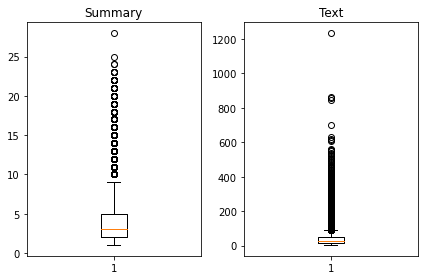

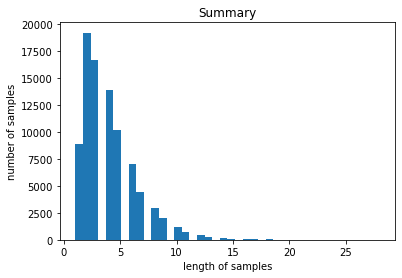

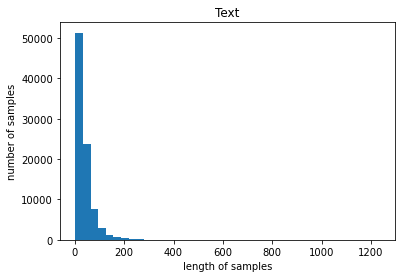

In [28]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

-------------------------------------

원문 텍스트는 대체적으로 100이하의 길이를 가집니다. 또한, 평균 길이는 38입니다. 요약의 경우에는 대체적으로 15이하의 길이를 가지며 평균 길이는 4입니다. 여기서 패딩의 길이를 정하겠습니다. 평균 길이보다는 크게 잡아 각각 50과 8로 결정합니다.

In [29]:
text_max_len = 50
summary_max_len = 8

50과 8이라는 이 두 길이가 얼마나 많은 샘플들의 길이보다 큰지 확인해보겠습니다.

In [30]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

우선 Text열에 대해서 확인해봅시다.

In [31]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


Text 열은 길이가 50 이하인 비율이 77%입니다. 약 23%의 샘플이 길이 50보다 큽니다. Summary 열에 대해서 확인해봅시다.

In [32]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


Summary 열은 길이가 8 이하인 경우가 94%입니다. 여기서는 정해준 최대 길이보다 큰 샘플들은 제거하겠습니다.

In [33]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


이제 샘플수가 65,818개로 줄었습니다. 정제 작업이 완료된 상위 샘플 5개를 출력해봅시다.

In [34]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다. 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 명명하고 앞, 뒤로 추가하겠습니다.

In [35]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


인코더의 입력, 디코더의 입력과 레이블을 각각 저장해줍니다.

In [36]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [37]:
np.random.seed(seed=0)

In [38]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[29546 43316 24839 ... 45891 42613 43567]


이 정수 시퀀스 순서를 데이터의 샘플 순서로 정의해주면 샘플의 순서는 섞이게 됩니다.

In [39]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해주겠습니다.

In [40]:
n_of_val = int(len(encoder_input)*0.2)
print(n_of_val)

13163


테스트 데이터는 전체 데이터에서 20%에 해당하는 13,163개를 사용하겠습니다.

In [41]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [42]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


#### 4) 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다. 우선, 원문에 해당되는 encoder_input_train에 대해서 수행합니다.

In [43]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 src_tokenizer.word_index에 저장되어져 있습니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [44]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32031
등장 빈도가 6번 이하인 희귀 단어의 수: 23779
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8252
단어 집합에서 희귀 단어의 비율: 74.23745746308263
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.393443023084609


등장 빈도가 threshold 값인 7회 미만. 즉, 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않습니다. 여기서는 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 배제시키고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8,233으로 계산했는데, 저자는 깔끔한 값을 선호하여 이와 비슷한 값으로 단어 집합의 크기를 8000으로 제한하겠습니다.

In [45]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

정수 인코딩이 정상 진행되었는지 훈련 데이터에 대해서 3개의 샘플을 출력해봅시다.

In [46]:
print(encoder_input_train[:5])

[[1882, 805, 844, 1855, 1120, 72, 131, 203, 1120, 83, 3896, 1, 1013, 844, 757, 167, 601, 350, 519, 435, 2482, 626, 72, 302, 1120, 132, 4281, 1007, 102, 449, 3450, 1, 75, 90, 343, 2307, 1188, 114, 1639, 166, 431, 1333, 1847, 70], [53, 4, 15, 901, 355, 37, 784, 97, 9, 8, 217, 441, 129, 101], [40, 1261, 473, 3, 909, 39, 3249, 2978, 221, 24, 37, 287, 2719, 6125, 56, 1371, 83, 390, 378], [1197, 9, 3147, 195, 1130, 105, 93, 836, 33, 803, 350, 145, 44, 328, 1707, 344, 85, 1510, 654, 578, 725, 24, 70, 212, 146, 302, 888, 574, 30, 191, 87, 4397], [5, 109, 254, 67, 706, 221, 698, 3017, 33, 152, 221, 1624, 55, 1029, 40, 1044, 20, 2681, 1430, 1624, 5861, 411, 435, 615, 78, 548, 2407, 438, 373, 127, 1624, 115, 42, 17, 254, 706, 16, 986, 14, 447, 2979, 7, 270, 953, 54]]


이제 레이블에 해당하는 요약 데이터에 대해서도 수행하겠습니다.

In [47]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tar_tokenizer.word_index에 저장되어져 있습니다. 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [48]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10510
등장 빈도가 5번 이하인 희귀 단어의 수: 8128
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2382
단어 집합에서 희귀 단어의 비율: 77.33587059942911
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.896286343062141


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.89%밖에 되지 않습니다. 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

In [49]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

In [50]:
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

정수 인코딩이 정상 진행되었는지 훈련 데이터에 대해서 5개의 샘플을 출력해봅시다.

In [51]:
print(decoder_input_train[:5])

[[1, 687], [1, 53, 21, 182, 1162, 240], [1, 6, 480, 113, 278, 181], [1, 15, 108, 215], [1, 54, 178, 21]]


In [52]:
print(decoder_target_train[:5])

[[687, 2], [53, 21, 182, 1162, 240, 2], [6, 480, 113, 278, 181, 2], [15, 108, 215, 2], [54, 178, 21, 2]]


In [53]:
print(decoder_input_test[:5])

[[1, 10, 12], [1, 590], [1, 118, 132, 262], [1, 6, 4], [1, 10, 11]]


In [54]:
print(decoder_target_test[:5])

[[10, 12, 2], [590, 2], [118, 132, 262, 2], [6, 4, 2], [10, 11, 2]]


#### 5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미합니다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높습니다. 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아옵시다. 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하여 단어 집합 제한에도 삭제 되지 않습니다. 그래서 이제 길이가 0이 된 요약문의 실질적 길이는 1입니다. decoder_input에는 sostoken, decoder_target에는 eostoken만 남았을 것이기 때문입니다.

In [55]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 저장하였습니다. 이 샘플들을 모두 삭제하고자 합니다. 삭제할 개수는 각각 몇개일까요?

In [56]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))

삭제할 훈련 데이터의 개수 : 1235


In [57]:
len(drop_test)

337

삭제 후의 개수는 다음과 같습니다.

In [58]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

In [59]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 51420
훈련 레이블의 개수 : 51420
테스트 데이터의 개수 : 12826
테스트 레이블의 개수 : 12826


#### 6) 패딩하기

앞서 계산해둔 최대 길이로 맞추어 훈련 데이터와 테스트 데이터에 대해서 패딩 작업을 수행합니다.

In [60]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')

decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

### 3. seq2seq + attention으로 요약 모델 설계 및 훈련시키기

우선 필요한 도구들을 임포트합니다.

In [61]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

인코더를 설계해보겠습니다. 인코더는 LSTM 층을 3개 쌓습니다.

In [62]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더를 설계해보겠습니다. 단, 출력층은 제외하고 설계하겠습니다. 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태(initial_state)를 인코더의 상태로 주어야 하는 것에 주의합시다.

In [63]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

이제 디코더의 출력층을 설계합니다.

In [64]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

 총 3,633,104개의 매개변수를 가진 seq2seq 모델이 설계됩니다. 

In [66]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

어텐션 메커니즘을 이용해 디코더의 출력층을 새롭게 설계합니다.

In [72]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

총 4,276,432개의 파라미터를 가진 모델이 설계됩니다. 이제 모델을 컴파일합니다.

In [73]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

조기 종료 조건을 설정하고 모델을 학습시킵니다.

In [76]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
201/201 [==============================] - 24s 113ms/step - loss: 2.6976 - val_loss: 2.4225
Epoch 2/50
201/201 [==============================] - 14s 70ms/step - loss: 2.3767 - val_loss: 2.3019
Epoch 3/50
201/201 [==============================] - 14s 71ms/step - loss: 2.2374 - val_loss: 2.1655
Epoch 4/50
201/201 [==============================] - 14s 70ms/step - loss: 2.1215 - val_loss: 2.0905
Epoch 5/50
201/201 [==============================] - 14s 70ms/step - loss: 2.0355 - val_loss: 2.0248
Epoch 6/50
201/201 [==============================] - 14s 70ms/step - loss: 1.9710 - val_loss: 1.9884
Epoch 7/50
201/201 [==============================] - 14s 72ms/step - loss: 1.9161 - val_loss: 1.9547
Epoch 8/50
201/201 [==============================] - 14s 72ms/step - loss: 1.8685 - val_loss: 1.9309
Epoch 9/50
201/201 [==============================] - 16s 78ms/step - loss: 1.8270 - val_loss: 1.9166
Epoch 10/50
201/201 [==============================] - 14s 72ms/step - loss: 1.78

학습 과정하면서 기록된 훈련 데이터의 손실과 테스트 데이터의 손실 히스토리를 시각화하여 출력합니다

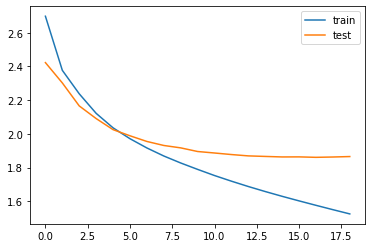

In [78]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

테스트 데이터의 손실이 지속적으로 줄어들다가 어느 순간부터 정체하게 됩니다.

### 4. seq2seq + attention으로 요약 모델 테스트하기

테스트를 위해 필요한 3개의 사전을 만듭니다.

In [79]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있습니다. 다시 새로운 seq2seq 모델을 만들겠습니다. 우선 인코더를 정의합니다.

In [80]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

이제 테스트 단계의 디코더를 설계합니다.

In [81]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [82]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

테스트 단계를 위한 모델이 완성되었습니다. 테스트를 위해 사용되는 함수 decode_sequence를 설계합니다.

In [83]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

테스트 단계에서 원문과 실제 요약문, 예측 요약문을 비교하기 위해 정수 시퀀스를 텍스트 시퀀스로 만드는 함수를 설계합니다.

In [84]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 샘플 중 500번부터 1000번까지 테스트해봅시다.

In [85]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  disappointing purchase two packages opened noodles fell apart many tiny pieces water bought noodles never happen guessing damage shipping 
실제 요약문 : in the water 
예측 요약문 :  not the best


원문 :  product along lines hamburger helper remember eating kid wanted try product liquid gold orzo pasta nice treat broccoli joke small little freeze dried broccoli cheese sauce strong smell mixed rest ingredients lost taste loved overall okay nothing special better making scratch 
실제 요약문 : kraft chicken and broccoli dinner kit 
예측 요약문 :  miracle


원문 :  tried many kinds coffee keep coming back newman love ordering amazon coffee right door cannot beat 
실제 요약문 : best coffee in 
예측 요약문 :  great coffee


원문 :  healthy tasty portable packets great go perfect gym bag cannot around fresh next best option pear mango flavor texture smooth applesauce recently packed work trip good way add little something healthy hotel fast food often dominate comes business travel 
실제 요약문 : great snack for adults 
예측 요약문

예측 요약문 :  love these


원문 :  first bought heb liked alot bought amazon larger size less best olive oil used thanks amazon 
실제 요약문 : really good tasting 
예측 요약문 :  great


원문 :  yo toddler picky eater however loves apple pear dry fruits eat bags snack 
실제 요약문 : my toddler loves it 
예측 요약문 :  my loves these


원문 :  yr old english usually bully sticks pet store visit found bones try fabulous awful smell keeps focused hours different layers bone keep interested read another review dog threw bone dogs sensitive skin stomachs never issue expensive bones well worth quality staying power 
실제 요약문 : excellent for chewers 
예측 요약문 :  my dogs love these


원문 :  highland sugarworks organic maple syrup far best maple syrup daughter tasted tried many brands including maple syrup produced individuals syrup best opportunity purchase months ago amazon com unfortunately price gone like everything else grocery related good hesitate try brands want disappointed buying near future 
실제 요약문 : maple syrup 
예측 요

예측 요약문 :  the best


원문 :  pro stuff fantastic salty buttery tastes like movie theater popcorn complain pop kernals thrown kettle others pop always fills tray comes popper way love 
실제 요약문 : tastes great 
예측 요약문 :  not bad


원문 :  people experience level greater others ginger takes away almost immediately like wonder drug without filling body drugs amazing 
실제 요약문 : ginger 
예측 요약문 :  good


원문 :  members family celiac disease everyone really enjoys mix easy make pleasantly surprised flavor texture typical pizza crust add herbs give great flavor made pizza mix crust nice crisp outside little chewy inside tried really horrible gluten free pizza crusts give discovered one kids actually fight last piece pizza make 
실제 요약문 : really great gluten free option 
예측 요약문 :  best gf mix mix


원문 :  awesome convenient product kids actually like better real taco filling much quicker make hamburger lower fat obviously stores much longer vegetarian try limit meat intake always use tacos glad amazon car

예측 요약문 :  great coffee


원문 :  product deserves stars amazon packaging deserves stars amazon ships sturdy books protective packaging delicate biscuits instead getting box six biscuits got box crumbs wish one biscuit even half intact complete waste money complete disappointment buy amazon 
실제 요약문 : do not buy from amazon 
예측 요약문 :  horrible


원문 :  getting hard find discs limited types coffee like gevalia better maxwell house gevalia bitter 
실제 요약문 : best decaf 
예측 요약문 :  best coffee ever


원문 :  dogs loved easy break smaller pieces complaints price amazon seemed reasonable compared costs pet stores 
실제 요약문 : two paws up 
예측 요약문 :  dogs love them


원문 :  kid taste like pasta however go extremely well vegetable stir fry practically negative calories apparently good 
실제 요약문 : good 
예측 요약문 :  good pasta


원문 :  sorry pass taste test always liked haribo brand gummies brand cut peach flavor gummies wrong type addition sour enough wish company send citric acid add gummies 
실제 요약문 : near harib

예측 요약문 :  good coffee


원문 :  first ordered try purchasing recipes using sounded something different ordered amazon cannot find area sweet rice cooking wine lot limit ordering amazon ever since love cook love product 
실제 요약문 : wonderful 
예측 요약문 :  the best


원문 :  ordering dip mix many years dip mix spicy vegetable dip desert top dips purchased 
실제 요약문 : one great dip 
예측 요약문 :  great


원문 :  never tried himalayan salt really like think strong normal white table salt tastier continue buy 
실제 요약문 : good salt 
예측 요약문 :  salt


원문 :  hard find tomato powder reasonably priced little tomato paste sauce requires cook somehow store extra unused portion 
실제 요약문 : at last priced powder 
예측 요약문 :  great product


원문 :  product makes coffee making quick easy put coffee packs pot need filters measuring unfortunately many supermarkets stopped carrying 
실제 요약문 : maxwell house decaffeinated filter packs 
예측 요약문 :  great coffee


원문 :  size consistency grind really quite good level saltiness expected 

예측 요약문 :  great product


원문 :  get stuff wished sold local stores ordered one day seems like got next 
실제 요약문 : pudding mix 
예측 요약문 :  great


원문 :  ordered product another item barry farm thru amazon ordered product stated item stock two weeks emailed asking status order emails never answered cancelled order thru amazon never received info barry farm order shipped appears stock understand buyer never barry farm 
실제 요약문 : stay away from 
예측 요약문 :  shipping


원문 :  cannot beat convenience tea strong enough get double volume one keurig cup 
실제 요약문 : favorite tea available for my keurig 
예측 요약문 :  great tea


원문 :  limited selection decaffeinated coffees espresso machines lavazza good non decaf selection lavazza best decaf espresso able find wife likes late make friend liked americano 
실제 요약문 : good espresso coffee 
예측 요약문 :  great for decaf


원문 :  stash decent brand tea got number varieties house use loose leaf tendency sometimes get loose leaf teeny tiny powder bits actually tell one 

예측 요약문 :  my dogs love it


원문 :  twizzlers much better individually wrapped product hits nail head ships fast stores great anywhere house really nice get craving red rope like candy 
실제 요약문 : is the best 
예측 요약문 :  great product


원문 :  bigelow winner strong overpowering mint taste black tea strong bitter unsure want buy bulk yet strongly suggest grabbing box grocery store 
실제 요약문 : extremely delicious 
예측 요약문 :  great taste


원문 :  know know real restaurants upon cannot even get least around live consider like cheap condiment real steak sauce like got tad zing goes much meat add heat want stir want say sauce way want quantity size bottles way go compares supermarket prices given tax shipping 
실제 요약문 : heinz still great 
예측 요약문 :  the best


원문 :  ginger ale made ginger idea except made celery quite ginger ale quite sprite something might little odd first time addictive acquired taste bad make diet version anymore one tasted regular 
실제 요약문 : something different 
예측 요약문 :  ginger ging

예측 요약문 :  love this soup


원문 :  highly recommend first bonsai tree need kit 
실제 요약문 : bonsai kit 
예측 요약문 :  great product


원문 :  lady grey favorite tea bit leery decaf version would hold great glad able find delicious tea drink night twinings lady grey decaf tea tea bags count boxes 
실제 요약문 : no decaf aftertaste 
예측 요약문 :  great tea


원문 :  far best granola bar tried kashi bar chewy really taste fruit nuts grams fiber grams protein whole grains feel like eating something good sugar grams find sweet 
실제 요약문 : best granola bars from kashi 
예측 요약문 :  great tasting snack


원문 :  find true lemon extremely convenient however packet indicates natural would like assured additional ingredients safe 
실제 요약문 : convenient but 
예측 요약문 :  not bad


원문 :  like espresso like chocolate find best world nothing else comes close 
실제 요약문 : the best in the world 
예측 요약문 :  best hot cocoa ever


원문 :  sorry coffee little roasted even thoughts burnt coffee go mind using friends cup coffee 
실제 요약문 : will not

예측 요약문 :  hot cocoa


원문 :  received package days good gladly opened one pack found smelled tasted like outdated also realized item returnable double disappointment last time buying product 
실제 요약문 : smell and taste 
예측 요약문 :  stale


원문 :  family gluten intolerant searched suitable replacement pamela products makes good bread mix tastes good pleasant texture freshly baked complaint crumbles easily days old 
실제 요약문 : good bread mix 
예측 요약문 :  great brownies


원문 :  quite expected coffee strong like even used bags could tell difference low acid make want go best ever could understand acid coffee brothers cup morning mama keeping regular brand 
실제 요약문 : not what expected 
예측 요약문 :  great coffee


원문 :  son little foodie months refused eat anything home made food lately started become different meals worried making son balanced meals insert happybaby super salmon oh god loves eats entire package reviewers complained smell yeah smells kind gross fish fish isnt known best odor would definet

예측 요약문 :  best tea ever


원문 :  excellent olive oil spice ideal dipping salads pasta certainly buy 
실제 요약문 : oil 
예측 요약문 :  the best


원문 :  ordered paying pet store prices greenies dogs godsend larger container affordable price would ever get anywhere else 
실제 요약문 : great value happy dogs 
예측 요약문 :  greenies


원문 :  used candy bar every one loved taste great thank hope get soon 
실제 요약문 : love it 
예측 요약문 :  delicious


원문 :  sure quality placed order since reviewers said prune hard dry first tried pleasantly since soft moist sweet buy running 
실제 요약문 : very good 
예측 요약문 :  delicious


원문 :  dog hates every food dogs treat ever found never refuses treats bit pricey go waste limit number eats day specified bag 
실제 요약문 : world dog loves these 
예측 요약문 :  my dog loves these


원문 :  enjoyed taste fear cannot say gave energy energy drinks market today since occasionally indulge energy drinks time time say delivered much energy supplement brands four stars mainly taste 
실제 요약문 : great taste 
예

예측 요약문 :  not


원문 :  buying local store great product 
실제 요약문 : is this really from box 
예측 요약문 :  great product


원문 :  favorite flavor kind bars since much fruit carbs lower looking extremely crunchy chewy great flavor definitely holds meals good stuff 
실제 요약문 : good and good for you 
예측 요약문 :  great


원문 :  tea looks great made disappointment worse tasted almost aroma tea weak pretty tasteless reason bought wife really loved dilmah earl grey loose leaf decided try dilmah one disappointed us would given stars sold premium price taken price value account give 
실제 요약문 : weak and tasteless 
예측 요약문 :  not bad


원문 :  bought dust local cake decorating supply store indeed beautiful another reviewer pointed label say decorative also says non toxic sure probably kill also clearly food product either manufacturer website 
실제 요약문 : beautiful but not as edible 
예측 요약문 :  not


원문 :  like buying package keeps running wish keurig made maker would fill cup lol sams club box love 
실제 요약문 : gotta h

예측 요약문 :  nasty


원문 :  product expected delivered indicated would definitely buy amazon price competitive 
실제 요약문 : greenies review 
예측 요약문 :  great


원문 :  great deal much bottles big value unbeatable shipped quickly delicious perfect bloody smoothies 
실제 요약문 : so much 
예측 요약문 :  great


원문 :  expecting much price good sugar chocolate fix actually quite tasty decent ingredients 
실제 요약문 : much better than expected good price 
예측 요약문 :  not bad


원문 :  bought cats picked ear product worked well clearing ear think directions mention use clean cat ears thoroughly get used product recommended twice day doses cats stopped scratching ears continued using another days make sure gone completely week free 
실제 요약문 : works well cats hate it though 
예측 요약문 :  great for cats with cats


원문 :  great tasting candies sugar free variety get sticky hard take individual wrappers especially without getting candy fingers 
실제 요약문 : great taste but hard to open 
예측 요약문 :  great


원문 :  cost item sure bring 

예측 요약문 :  great alternative to sugar


원문 :  price paid starbucks french roast pound bag less paid local grocery store ounce bag love deep flavor coffee purchase form vendor 
실제 요약문 : great coffee best price 
예측 요약문 :  good coffee


원문 :  cats royal canin adult one dry fur switched intense beauty nine months ago really given thick soft coat vet even commented soft fur course food good overall well cats healthy nice find pet food works advertised 
실제 요약문 : really makes difference 
예측 요약문 :  my cats love this


원문 :  pasta hold shape ends mushy mess even reducing cooking time rinsing cold water tinkyada spaghetti improvement shells hesitant try shapes ended numerous bags mush 
실제 요약문 : not the best 
예측 요약문 :  not the best


원문 :  happy product paid extra get fast think took days whats point day shipping get 
실제 요약문 : kefir grains 
예측 요약문 :  great product


원문 :  looking replacement chocolate chip peanut bars tried would go back bars flash whole peanuts whole choc chips bars like stale ri

실제 요약문과 완전히 똑같지 않으면서 원문의 맥락을 잘 잡아서 예측된 요약문들이 존재하는 것을 확인할 수 있습니다.

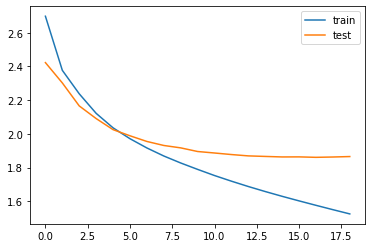

In [86]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [87]:
encoder_input_train[5]

array([   7,   46,  324,  929,   34,  346, 4398,    6,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [88]:
decoder_input_train[5]

array([  1, 591,  14,   0,   0,   0,   0,   0])

In [89]:
decoder_target_train[5]

array([591,  14,   2,   0,   0,   0,   0,   0])